## Demo of Probabilistic Tensor Decomposition of Neural Population Spiking Activity

### Preamble

In this notebook, we illustrate the probabilistic decomposition of a partially observed rank 4 count tensor (of size <small> $100 \times 70 \times 3 \times 4 \times 5$ </small>) defined by


  

$ (\mathcal{X} | \mathcal{W}, \mathcal{V}, \zeta) \sim \text{Negative Binomial}(\zeta, p),$

where

- $\mathcal{W} = [|A^{(1)}, ..., A^{(5)}|]$ is a low rank tensor whose Canonical Polyadic (CP) decomposition we are looking for.

- $\mathcal{V}$ is a tensor constrained to vary only across the first and third dimension

- $\zeta$ is a shape parameter

- $p =  \frac{1}{ 1+e^{\mathcal{W}+ \mathcal{V}} }.$

In addition, we assume that we dispose of three "neurons" groups defined such that $A^{(1)}$ is a block sparse matrix.


### Generate toy dataset

Text(0.5, 0.98, 'True Factors W = [|A1, .., A5|]')

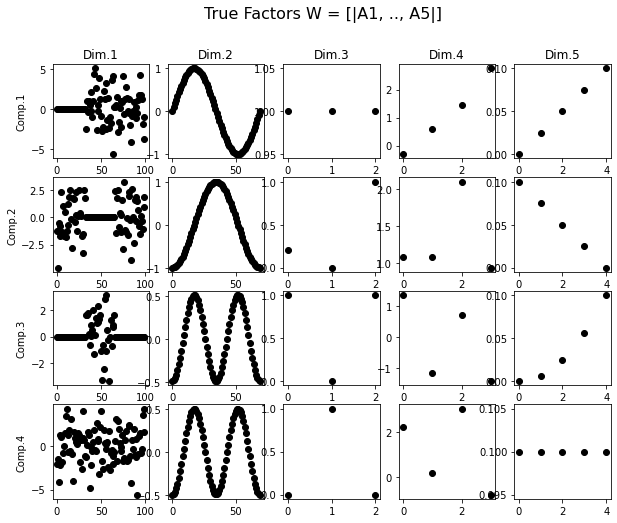

In [1]:
# Imports and random seeds
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'..')
from vbgcp.vb_gcp import VBGCPTensor
from vbgcp.components import FitParams
from examples.toydata import build_toydaset
from vbgcp.utils import (plot_factors, expand_factors, get_similarity, reorder_models)
np.random.seed(1)


# Build toy data set with an offset
params = build_toydaset(add_offset=1)

# Factors W = [|A1,.., A5|]
factors_true = params['factors']

# Constrained Offset V
offset_true = params['offset']
offset_dim = params['offset_dim']

# Observed counts X
observed_tensor = params['observed_tensor']

# Neuron Groups
neuron_groups = params['neurons_groups']
shared_precision_mode = 0

# Observe only ~ 50% of the full tensor
observed_data = np.random.rand(*observed_tensor.shape) > 0.5
observed_tensor = observed_tensor * observed_data

# Plot true factors
fig = plt.figure(figsize=(10,8))
plot_factors(factors_true)
fig.suptitle('True Factors W = [|A1, .., A5|]', fontsize=16)



### Probabilistic Tensor Decomposition: Fit with ARD

In [2]:
# Putative tensor rank
tensor_rank = 6

# Run variational inference
fit_params = FitParams(observed_tensor.shape, tensor_rank,
                       observed_data=observed_data, fit_offset_dim=offset_dim,
                       shared_precision_dim=[0, 1, 1, 1, 1], shared_precision_mode=shared_precision_mode,
                       neuron_groups=neuron_groups, ite_max=4000, disppct=400)

vbgcp = VBGCPTensor(observed_tensor.shape, tensor_rank, shape_param=120, fit_params=fit_params)
vbgcp.variational_inference(observed_tensor)

Iterations: 0000 / 4000 | loss =   -74096150.9598 | shape =   119.6997
Iterations: 0400 / 4000 | loss =   -74225213.3345 | shape =   107.7633
Iterations: 0800 / 4000 | loss =   -74225625.7095 | shape =   99.1224
Iterations: 1200 / 4000 | loss =   -74226688.6042 | shape =   92.8551
Iterations: 1600 / 4000 | loss =   -74226767.6990 | shape =   88.5330
Iterations: 2000 / 4000 | loss =   -74226807.0855 | shape =   85.6874
Iterations: 2400 / 4000 | loss =   -74226829.6235 | shape =   83.8745
Iterations: 2800 / 4000 | loss =   -74226839.8265 | shape =   82.7452
Iterations: 3200 / 4000 | loss =   -74226843.8370 | shape =   82.0518
Iterations: 3600 / 4000 | loss =   -74226848.2567 | shape =   81.6304


###  Plot Results Summary

Text(0.5, 0.98, 'Fit Summary')

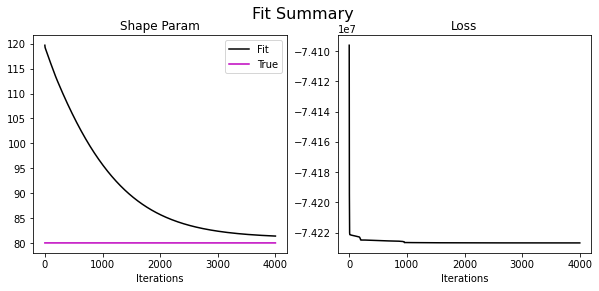

In [3]:
fig2 = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(vbgcp.shape_param_tot, color='k', label='Fit')
plt.plot(np.ones(len(vbgcp.shape_param_tot))*params['model']['shape'], color='m', label='True')
plt.legend()
plt.title('Shape Param')
plt.xlabel('Iterations')

plt.subplot(1, 2, 2)
plt.plot(vbgcp.loss_tot, color='k')
plt.xlabel('Iterations')
plt.title('Loss')

fig2.suptitle('Fit Summary', fontsize=16)


### Discovered Factors

[0.9999999999919229, 0.9747965291326792]
No ordering provided. Ordering with default values


Text(0.5, 0.98, 'True Factors (magenta) Vs ARD Fit (black))')

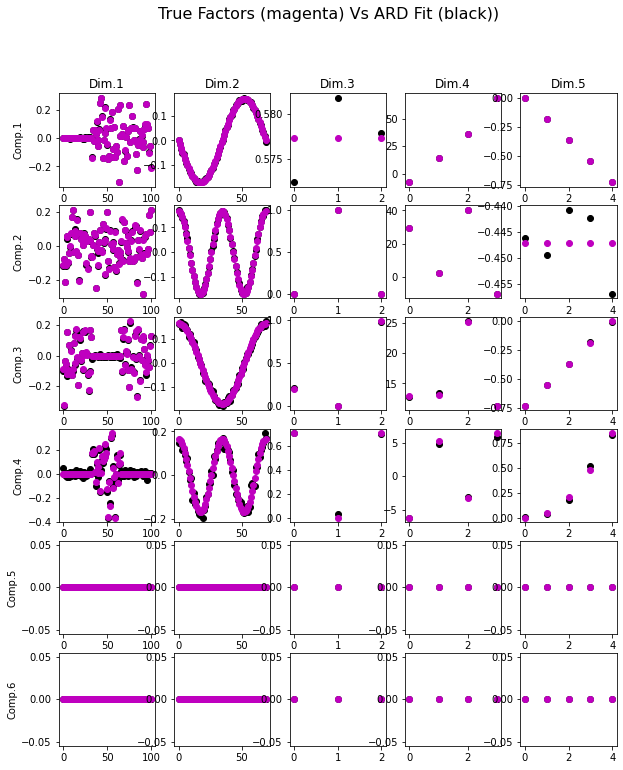

In [4]:
models = [expand_factors(factors_true, 6), vbgcp.posteriors.factors_mean]
smlty, _,_ = get_similarity(models)
print(smlty)
models = reorder_models(models)


fig3 = plt.figure(figsize=(10,12))
plot_factors(models[1], color='k')
plot_factors(models[0], color='m')
fig3.suptitle('True Factors (magenta) Vs ARD Fit (black))', fontsize=16)

### Factors Posteriors

[0.9999999999919229, 0.9747965291326792]
No ordering provided. Ordering with default values


Text(0.5, 0.98, 'Factors and 1 std')

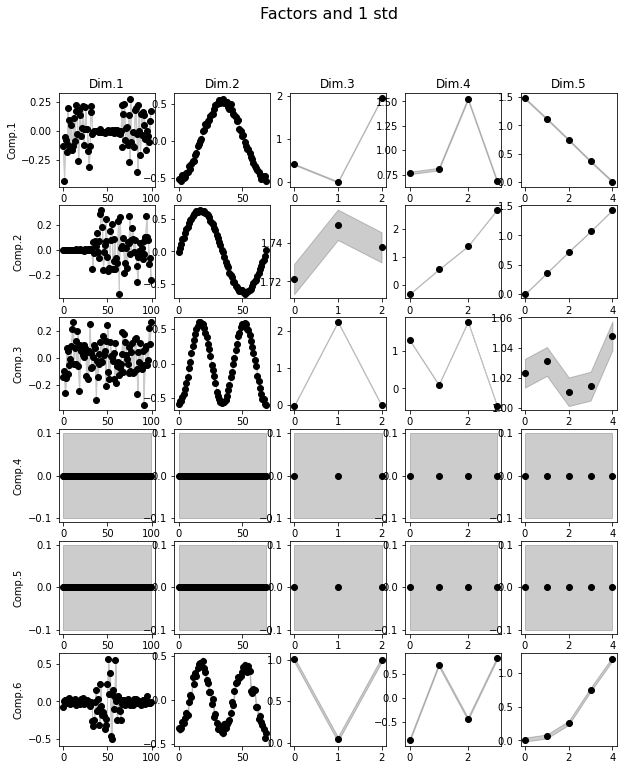

In [5]:
# Plot with CI 
models = [expand_factors(factors_true, 6), vbgcp.posteriors.factors_mean]
smlty, _,_ = get_similarity(models)
print(smlty)
models = reorder_models(models)


fig3 = plt.figure(figsize=(10,12))
plot_factors(vbgcp.posteriors.factors_mean, vbgcp.posteriors.factors_variance, color='k')
fig3.suptitle('Factors and 1 std', fontsize=16)


### Offset posteriors

Text(0.5, 0.98, 'Offset')

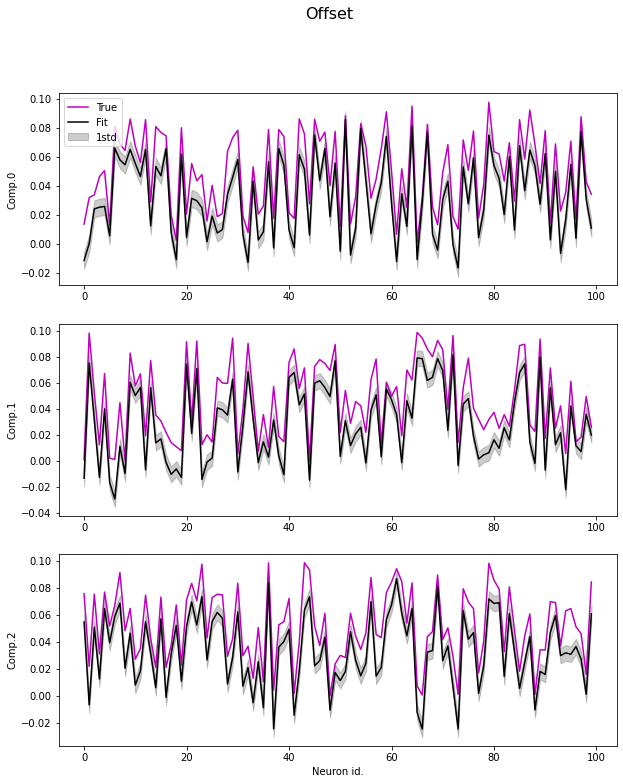

In [6]:

offset_true = np.squeeze(params['offset'])
offset_fit = vbgcp.posteriors.offset_mean[:, 0, :, 0, 0]
offset_var = vbgcp.posteriors.offset_variance[:, 0, :, 0, 0]


fig4 = plt.figure(figsize=(10,12))
for ii in np.arange(offset_true.shape[1]):

    xcur = np.arange(len(offset_fit[:, ii]))
    true_cur = offset_true[:, ii]
    fit_cur = offset_fit[:, ii]

    plt.subplot(offset_true.shape[1], 1, ii+1)
    plt.plot(xcur, true_cur, c='m', label='True')
    plt.plot(xcur, fit_cur, c='k', label='Fit')


    up = fit_cur + 1 * np.sqrt(offset_var[:, ii])
    lo = fit_cur - 1 * np.sqrt(offset_var[:, ii])
    plt.fill_between(xcur, lo, up, color='k', alpha=0.2, label='1std')
    
    plt.ylabel('Comp.' + str(ii))
    
    if ii ==0:
        plt.legend()
    elif ii == (offset_true.shape[1]-1):
        plt.xlabel('Neuron id.')
        
fig4.suptitle('Offset', fontsize=16)


### For comparison: Fit without ARD

In [7]:
# Run variational inference With No ARD
fit_params_no_ard = FitParams(observed_tensor.shape, tensor_rank,
                       observed_data=observed_data, fit_offset_dim=offset_dim,
                       neuron_groups=neuron_groups, ite_max=4000, disppct=400)

vbgcp_no_ard = VBGCPTensor(observed_tensor.shape, tensor_rank, shape_param=120, fit_params=fit_params_no_ard)
vbgcp_no_ard.variational_inference(observed_tensor)

Iterations: 0000 / 4000 | loss =   -74084379.5810 | shape =   119.7322
Iterations: 0400 / 4000 | loss =   -74216124.4440 | shape =   106.9589
Iterations: 0800 / 4000 | loss =   -74222741.5593 | shape =   98.0084
Iterations: 1200 / 4000 | loss =   -74223475.6171 | shape =   92.1865
Iterations: 1600 / 4000 | loss =   -74223908.3418 | shape =   88.2025
Iterations: 2000 / 4000 | loss =   -74224234.3230 | shape =   85.5875
Iterations: 2400 / 4000 | loss =   -74224450.2928 | shape =   83.9223
Iterations: 2800 / 4000 | loss =   -74224587.1826 | shape =   82.8832
Iterations: 3200 / 4000 | loss =   -74224699.5083 | shape =   82.2436
Iterations: 3600 / 4000 | loss =   -74224802.2949 | shape =   81.8533


[0.9999999999919229, 0.9784128427585721]
No ordering provided. Ordering with default values


Text(0.5, 0.98, 'True Factors (magenta) Vs No-ARD Fit (black))')

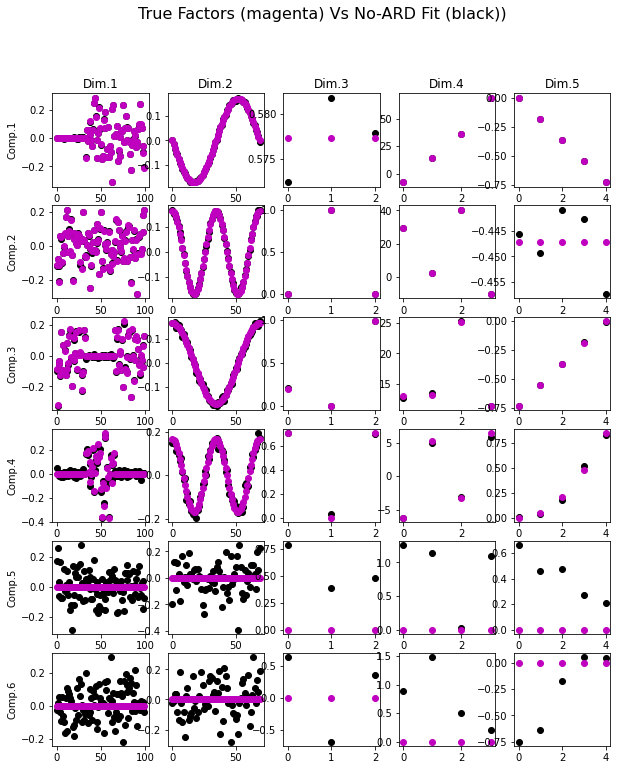

In [9]:
models = [expand_factors(factors_true, 6), vbgcp_no_ard.posteriors.factors_mean]
smlty, _,_ = get_similarity(models)
print(smlty)
models = reorder_models(models)


fig3 = plt.figure(figsize=(10,12))
plot_factors(models[1], color='k')
plot_factors(models[0], color='m')
fig3.suptitle('True Factors (magenta) Vs No-ARD Fit (black))', fontsize=16)